# Tópico 13 – Bootstrapping [<img src="images/colag_logo.svg" style="float: right; margin-right: 0%; vertical-align: middle; width: 6.5%;">](https://colab.research.google.com/github/urielmoreirasilva/urielmoreirasilva.github.io/blob/main/aulas/T%C3%B3pico%2013%20%E2%80%93%20Bootstrapping/13%20%E2%80%93%20Bootstrapping.ipynb) [<img src="images/github_logo.svg" style="float: right; margin-right: 0%; vertical-align: middle; width: 3.25%;">](https://github.com/urielmoreirasilva/urielmoreirasilva.github.io/blob/main/aulas/T%C3%B3pico%2013%20%E2%80%93%20Bootstrapping/13%20%E2%80%93%20Bootstrapping.ipynb)

Nessa aula, vamos aprender como quantificar a incerteza sobre nossas estimativas e como aplicar uma técnica pioneira que nos permite, com base em uma única amostra, simular diferentes cenários possíveis para as nossas estimativas.

### Resultados Esperados

1. Entender mais sobre o papel das distribuições amostrais na quantificação de incerteza sobre nossas estimativas.
1. Aprender sobre as potencialidades do bootstrap, e aprender como operacionalizá-lo na prática.
1. Introduzir os conceitos de percentis e como usá-los nesse contexto.

### Referências
- [CIT, Capítulo 13](https://inferentialthinking.com/)

Material adaptado do [DSC10 (UCSD)](https://dsc10.com/) por [Flavio Figueiredo (DCC-UFMG)](https://flaviovdf.io/fcd/) e [Uriel Silva (DEST-UFMG)](https://urielmoreirasilva.github.io)

In [2]:
# Imports para esse tópico.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Opções de como printar objetos do Numpy e do Pandas.
np.set_printoptions(threshold = 20, precision = 2, suppress = True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

### Exemplo motivador: Salários dos funcionários públicos da cidade de San Diego

Vamos começar essa aula com um exemplo motivador: [os salários de todos os funcionários públicos da cidade de San Diego, no ano de 2022](https://publicpay.ca.gov/Reports/Cities/City.aspx?entityid=405&year=2021&rpt=1).

In [4]:
population = pd.read_csv('data/2022_salaries.csv')
population

,Year,EmployerType,EmployerName,DepartmentOrSubdivision,...,EmployerCounty,SpecialDistrictActivities,IncludesUnfundedLiability,SpecialDistrictType
0,2022,City,San Diego,Police,...,San Diego,NaN,False,NaN
1,2022,City,San Diego,Police,...,San Diego,NaN,False,NaN
2,2022,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...
12826,2022,City,San Diego,Public Utilities,...,San Diego,NaN,False,NaN
12827,2022,City,San Diego,Police,...,San Diego,NaN,False,NaN
12828,2022,City,San Diego,Police,...,San Diego,NaN,False,NaN


Quando trabalhamos com um base de dados com um número grande de colunas, não conseguimos visualizá-las todas ao mesmo tempo. Nesses casos, é sempre uma boa ideia analisarmos os nomes das colunas.

In [6]:
population.columns

Index(['Year', 'EmployerType', 'EmployerName', 'DepartmentOrSubdivision',
       'Position', 'ElectedOfficial', 'Judicial', 'OtherPositions',
       'MinPositionSalary', 'MaxPositionSalary', 'ReportedBaseWage',
       'RegularPay', 'OvertimePay', 'LumpSumPay', 'OtherPay', 'TotalWages',
       'DefinedBenefitPlanContribution', 'EmployeesRetirementCostCovered',
       'DeferredCompensationPlan', 'HealthDentalVision',
       'TotalRetirementAndHealthContribution', 'PensionFormula', 'EmployerURL',
       'EmployerPopulation', 'LastUpdatedDate', 'EmployerCounty',
       'SpecialDistrictActivities', 'IncludesUnfundedLiability',
       'SpecialDistrictType'],
      dtype='object')

Como aqui estamos interessados apenas nos salários totais (`'TotalWages'`), selecionaremos apenas essa coluna.

In [8]:
## NOTA: como o resultado do subset "[.]" abaixo retorna uma Series,
## ---- precisamos transformar o resultado em um DataFrame 
## ---- para poder continuar utilizando os métodos de Pandas 
## ---- para DataFrames
population = pd.DataFrame(population['TotalWages'])
population

,TotalWages
0,384909
1,381566
2,350013
...,...
12826,6
12827,4
12828,2


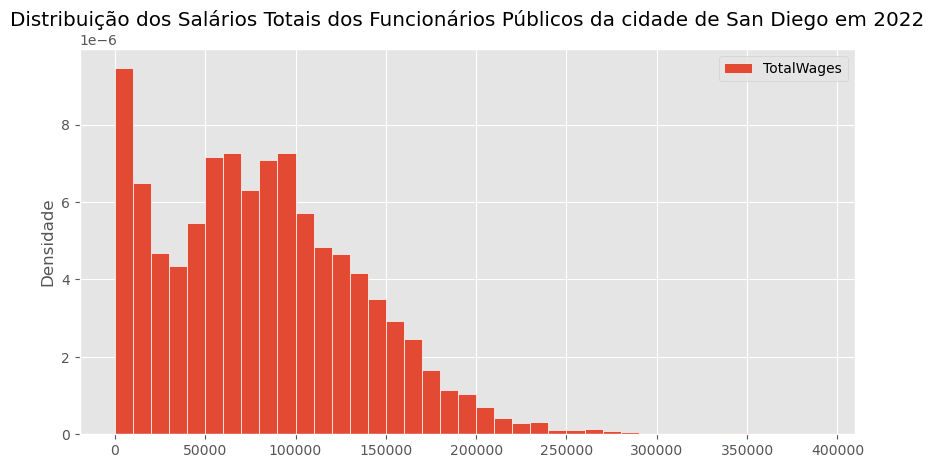

In [9]:
population.plot(kind = 'hist', bins = np.arange(0, 400000, 10000), density = True, ec = 'w', figsize = (10, 5),
                title = 'Distribuição dos Salários Totais dos Funcionários Públicos da cidade de San Diego em 2022')
plt.ylabel('Densidade');

#### Salário mediano na população

- Suponha que estejamos interessados no salário mediano dos funcionários públicos da cidade de San Diego.
- Podemos utilizar a função `.median()` para calcular o salário mediano de todos os funcionários, operando na `Series` `population.get('TotalWages')`.
- Note que, como temos a população _inteira_ disponível, essa mediana é um **parâmetro**, i.e. **não-aleatória**.

In [11]:
population_median = population['TotalWages'].mean()
population_median

82015.97833034532

#### Salário mediano na amostra

- Na prática, porém, o processo de entrevistar **toda** a população (no caso mais de 12,000 funcionários) é caro e pode consumir muito tempo.
- Além disso, muitas vezes é _impossível_ entrevistar todos os indivíduos da população.
- O que fazemos então é aferir os salários com base em uma **amostra aleatória** (nesse exemplo tomamos $n = 500$).

**Nota**: a terminologia "amostra aleatória" é um sinônimo para amostras que foram coletadas via **amostragem aleatória simples** (lembre-se: de maneira _uniforme_, _independente_ e _sem reposição_). 

### Revisão rápida da terminologia

- O DataFrame completo de salários, i.e. `population.get(['TotalWages'])`, é a nossa **população**.

- Nós observamos uma **amostra** de tamanho $n = 500$ dessa população.

- Queremos determinar a **mediana populacional** (que é um _parâmetro_), mas como não temos acesso à população completa, utilizaremos a **mediana amostral** (que é uma _estatística_) como uma **estimativa** desse parâmetro.

- Nesse processo, esperamos que a mediana amostral seja "próxima" da mediana populacional.

### A mediana amostral

Vamos amostrar 500 funcionários aleatoriamente. Para fazer isso, podemos utilizar o método `.sample`.

In [19]:
## Fixando a semente aleatória para garantir reproducibilidade
np.random.seed(42) 

## Amostrando sem reposição, com n = 500
my_sample = population.sample(500)
my_sample

,TotalWages
9033,48705
5749,85814
385,194013
...,...
4295,101531
653,176438
7600,64136


Nesse notebook, não vamos mais modificar `my_sample`, então esse DataFrame vai sempre se referir à essa amostra em particular.

A mediana amostral dos salários, isto é, a mediana da coluna `TotalWages` em `my_sample`, é igual a:

In [22]:
sample_median = my_sample['TotalWages'].median()
sample_median

73264.5

### E o quão "confiantes" podemos estar que uma estimativa é uma boa estimativa? 🤔

- Nossa estimativa é função da amostra aleatória particular `my_sample`. Se tívessemos coletado outra amostra, a estimativa poderia ter sido diferente.

- **Agora, o quão diferente nossa estimativa poderia ter sido?** Nosssa _confiança_ na estimativa depende fundamentalmente da resposta à essa pergunta.

- A mediana amostral é um número aleatório. Esse número vem de uma distribuição, que não conhecemos!

- **Se** conhecéssemos a distribuição verdadeira da mediana amostral (i.e. sua **distribuição amostral**), essa distribuição nos ajudaria a responder essa pergunta.
    - Distribuições mais "estreitas" (i.e. com baixa _variabilidade/dispersão_) $\Rightarrow$ nossa estimativa em geral não teria sido tão diferente.
    - Distribuições mais "largas" (i.e. com alta variabilidade/dispersão) $\Rightarrow$ nossa estimativa em geral teria sido bem diferente.

### Uma abordagem inviável

- Uma ideia natural aqui então seria: coletar repetidas amostras de tamanho $n = 500$ **da população**, e então calcular as medianas amostrais de cada uma.
  - Lembre que foi examente isso o que fizemos no Tópico 12, quando calculamos a distribuição amostral empírica das médias amostrais dos atrasos de vôos.

In [29]:
## Nota: o resultado abaixo é estocástico!

sample_medians = np.array([])
for i in np.arange(1000):
    median = population['TotalWages'].sample(500).median()
    sample_medians = np.append(sample_medians, median)
sample_medians

array([80112. , 80582. , 79678.5, ..., 76866.5, 80390. , 78297.5])

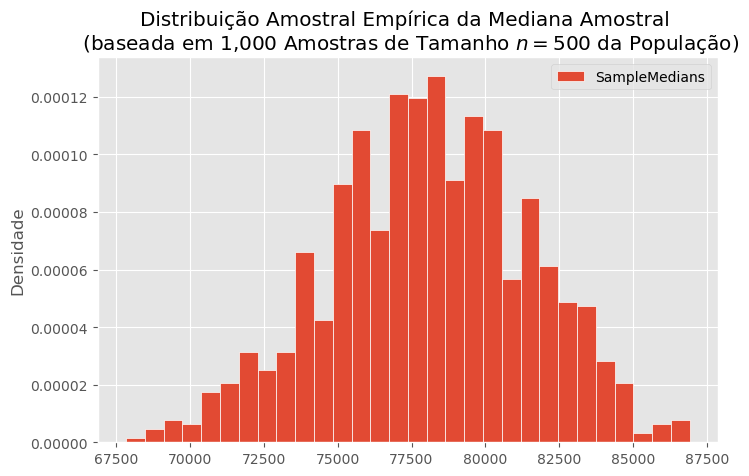

In [30]:
(pd.DataFrame({"SampleMedians" : sample_medians})
    .plot(kind = 'hist', density = True,
       bins = 30, ec = 'w', figsize = (8, 5),
       title = 'Distribuição Amostral Empírica da Mediana Amostral \n (baseada em 1,000 Amostras de Tamanho $n = 500$ da População)')
)
plt.ylabel("Densidade");

### E porque essa abordagem é inviável?

- Amostrar repetidas vezes da mesma população muitas vezes é **inviável pelas mesmas razões pelas quais não trabalhamos com a população desde o começo**!
- Se pudéssemos fazer isso, seria melhor simplesmente coletarmos uma amostra maior!

## Bootstrapping 🥾

### Bootstrapping

- **Ideia principal**: Utilizar a amostra no lugar da população no procedimento descrito acima.  
    - Nesse caso, _reamostramos da amostra_, o que de certa maneira é similar à reamostrar da própria população!
    - Denominamos o conjunto de técnicas que se baseiam em reamostragens a partir da amostra de **bootstrapping**.

### Com reposição ou sem reposição?

- Nosso objetivo quando realizamos um bootstrap é gerar uma amostra do _mesmo tamanho_, porém com _algumas características_ diferentes da amostra original.
- Para ilustrar esse ponto, considere um exemplo simples onde vamos reamostrar repetidas vezes, **sem reposição**, uma amostra do DataFrame `original`.

In [37]:
original = [1, 2, 3]
for i in np.arange(10):
    resample = np.random.choice(original, 3, replace=False)
    print("Resample: ", resample, "    Median: ", np.median(resample))

Resample:  [1 3 2]     Median:  2.0
Resample:  [2 3 1]     Median:  2.0
Resample:  [3 2 1]     Median:  2.0
Resample:  [2 3 1]     Median:  2.0
Resample:  [3 2 1]     Median:  2.0
Resample:  [3 2 1]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [1 3 2]     Median:  2.0
Resample:  [2 1 3]     Median:  2.0


- Vamos agora repetir o mesmo experimento, mas dessa vez reamostrando **com reposição**:

In [39]:
original = [1, 2, 3]
for i in np.arange(10):
    resample = np.random.choice(original, 3, replace=True)
    print("Resample: ", resample, "    Median: ", np.median(resample))

Resample:  [3 1 2]     Median:  2.0
Resample:  [1 1 3]     Median:  1.0
Resample:  [3 1 1]     Median:  1.0
Resample:  [3 3 1]     Median:  3.0
Resample:  [2 1 3]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [2 3 3]     Median:  3.0
Resample:  [3 3 1]     Median:  3.0
Resample:  [1 1 3]     Median:  1.0


Concluímos com esse exemplo que:
    
- Quando amostramos _sem reposição_, as novas amostras (**amostras bootstrap**) são em um certo sentido "idênticas" à amostra original – mudamos apenas a ordenação dos indivíduos.
- Como consequência, todas as suas características (isto é, estatísticas), são _iguais_!

- Por outro lado, quando amostramos _com reposição_, as amostras bootstrap em geral terão características diferentes da amostra original.
- As estatísticas calculadas com base nas amostras bootstrap em geral serão _diferentes_ das calculadas com base na amostra original, e isso nos permite _aferir a variabilidade das estimativas_ entre as amostras e/ou construir uma **distribuição amostral empírica** para nossas estatísticas de interesse!

- Dessa forma, quando realizamos um bootstrap, **sempre reamostramos com reposição**, para garantir que as nossas amostras bootstrap possam ser _diferentes_ da nossa amostra original.
- O bootstrap funciona então como um processo que "imita", em um certo sentido, o ato de coletar novas amostras!

### Bootstrap na amostra de salários

Conforme dito anteriormente, para realizar o bootstrap na nossa amostra, basta gerarmos novas amostras **reamostrando com reposição da nossa amostra original**, `my_sample`:

In [44]:
## Fixando a semente aleatória para garantir reproducibilidade
np.random.seed(42)

## Número de amostras bootstrap
n_resamples = 5000
boot_medians = np.array([])

## Loop `for` principal
for i in range(n_resamples):
    
    # Reamostrando de `my_sample` COM REPOSIÇÃO
    resample = my_sample.sample(500, replace = True)
    
    # Calculando a mediana da amostra bootstrap
    median = resample['TotalWages'].mean()
    
    # Salvando o resultado em um array
    boot_medians = np.append(boot_medians, median)

- No código acima,
    1. Reamostramos $B = 5.000$ vezes da amostra `my_sample` com reposição, produzindo $B = 5.000$ amostras bootstrap de tamanho $n = 500$;
    2. Para cada uma das $B = 5.000$ amostras bootstrap, calculamos a mediana amostral correspondente e salvamos o resultado em um array `boot_medians`;
    3. Retornamos o array `boot_medians`, de tamanho $B = 5.000$, contendo a mediana amostral de cada amostra.

In [46]:
boot_medians

array([84438.12, 78331.71, 80288.7 , ..., 81285.45, 77816.16, 76002.23])

- O resultado do processo descrito acima é uma **distribuição boostrap**, que então utilizamos como uma _aproximação_ para a **distribuição amostral** da mediana amostral.
    - Em outras palavras, a distribuição bootstrap é uma **distribuição amostral empírica** da mediana amostral.

- Note que o processo operacional para realizarmos uma amostragem bootstrap é bem similar ao processo de simulação para estimar probabilidades que vimos no Tópico 11.

> É importante ressaltar, porém, que em _momento algum_ utilizamos a população `population` aqui – todo o processo foi feito **apenas com base na amostra** `my_sample`!

### _Distribuição bootstrap_ da mediana amostral

Vamos agora elaborar um histograma para visualizar a distribuição bootstrap da mediana amostral:

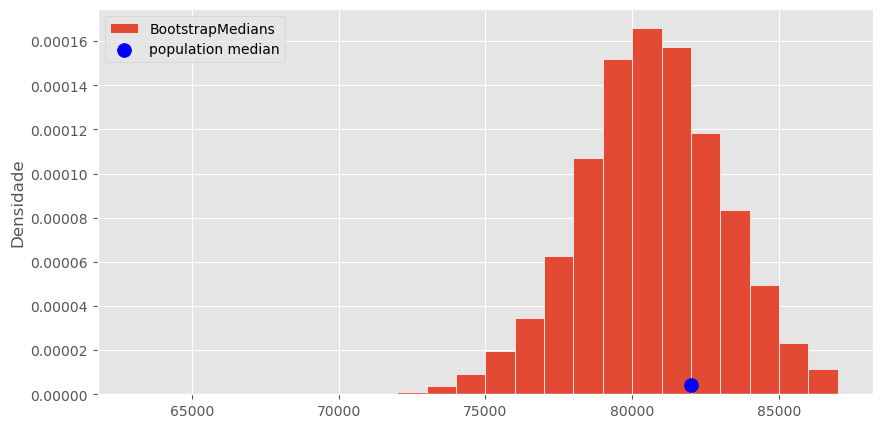

In [51]:
(pd.DataFrame({"BootstrapMedians" : boot_medians})
    .plot(kind = 'hist', density = True, bins = np.arange(63000, 88000, 1000), ec = 'w', figsize = (10, 5))
)
plt.scatter(population_median, 0.000004, color = 'blue', s = 100, label = 'population median').set_zorder(2)
plt.legend()
plt.ylabel("Densidade");

_Apenas para termos uma referência_ do quão boa é nossa inferência, a mediana populacional é reportada no histograma acima como um <span style="color:blue"><b>ponto azul</b></span>.

**Lembre porém que, na maior parte das situações, não temos acesso à essa informação!**

### Mas afinal, como o bootstrap nos ajuda a responder nossa pergunta original?

Lembre que, aqui, iniciamos apenas com a mediana amostral:

In [54]:
my_sample['TotalWages'].median()

73264.5

Com base nessa estimativa, podemos dizer apenas que o salário mediano da população é "aproximadamente" \\$76,237, mas não muito mais do que isso.

Em particular, não podemos afirmar nada acerca da _variabilidade_ dessa estimativa, isto é, o quão _confiantes_ (ou incertos!) estamos sobre esse valor.

Com o boostrap, porém, podemos aproximar a **distribuição amostral empírica da mediana amostral**:

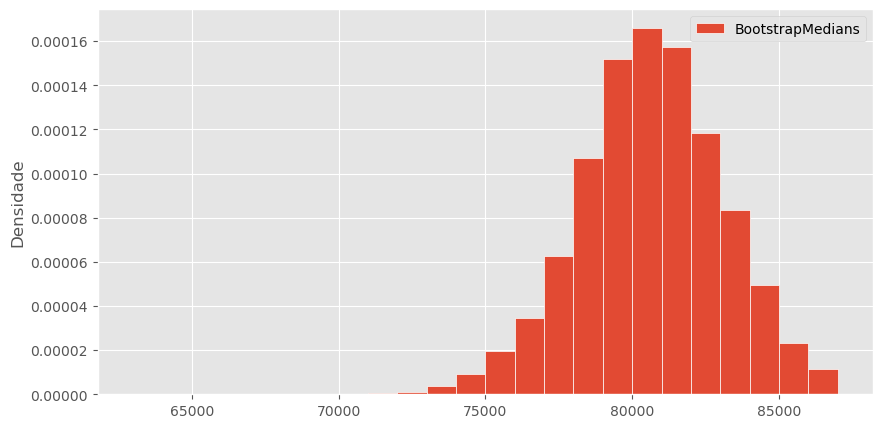

In [57]:
(pd.DataFrame({"BootstrapMedians" : boot_medians})
    .plot(kind = 'hist', density = True, bins = np.arange(63000, 88000, 1000), ec = 'w', figsize = (10, 5))
)
plt.legend()
plt.ylabel("Densidade");

e essa distribuição nos permite realizar afirmações do tipo

> "Com uma frequência razoável", o salário mediano na população está entre \\$68,000 e \\$82,000.

**Pergunta**: Poderíamos também dizer que o salário mediano na população está entre \\$70,000 e \\$80,000, ou entre \\$65,000 e \\$85,000. Qual desses dois intervalos você reportaria? Por que?

### Exercício ✅

Suponha que em uma pesquisa eleitoral tenhamos coletado uma amostra de $n$ eleitores, e estejamos interessados na proporção de eleitores que disseram votariam no candidato A. 

Escreva na célula abaixo um simples _pseudoalgoritmo_ detalhando como utilizar o bootstrap para aproximar a distribuição amostral da proporção amostral nesse caso.

## Percentis

### Definição

> Seja $p$ um número entre 0 e 100. O $p$-ésimo percentil de um conjunto de observações $\boldsymbol{X}$ (usualmente denotado por $Q_p(\boldsymbol{X})$) é o _menor número_ que é maior ou igual a $p\%$ de todos os valores de $\boldsymbol{X}$.

**Exemplo** – escores no SAT:
<center><img src="images/percentile2.jpg" width=600></center>

**Outro exemplo**: Se você está no percentil $80$ da altura de um certo conjunto de pessoas, isso significa que aproximadamente $80\%$ das pessoas desse conjunto são mais baixas que você, e que $20\%$ são mais altas.

<center><img src="images/percentile.svg" width=400></center>

### Calculando percentis

- O pacote `numpy` contém uma função para calcular percentis, `np.percentile(array, p)`, que retorna o `p`-ésimo percentil de `array`. 
- Por enquanto, não entraremos em detalhes sobre como esse valor é calculado; nos concentraremos apenas em sua utilização e interpretação.

In [67]:
np.percentile([4, 6, 9, 2, 7], 50)

6.0

In [68]:
np.percentile([2, 4, 6, 7, 9], 50)

6.0

Voltando ao nosso exemplo dos salários, temos uma distribuição boostrap da mediana amostral:

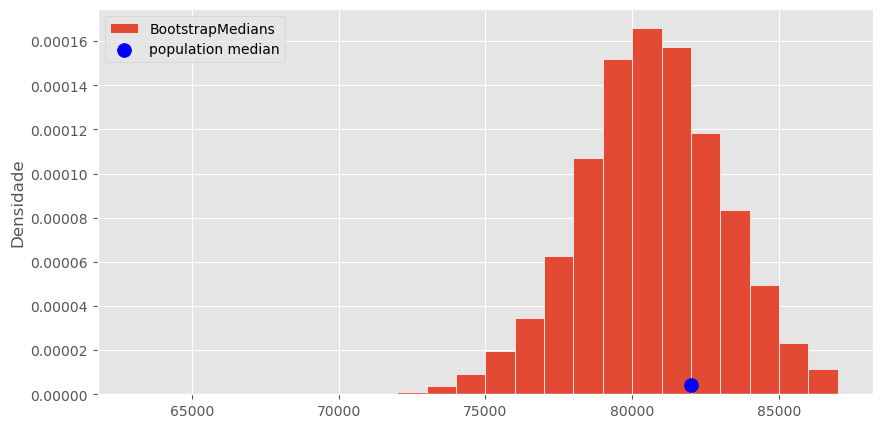

In [70]:
pd.DataFrame({"BootstrapMedians" : boot_medians}).plot(kind = 'hist', density = True, bins = np.arange(63000, 88000, 1000), ec = 'w', figsize = (10, 5))
plt.scatter(population_median, 0.000004, color = 'blue', s = 100, label = 'population median').set_zorder(2)
plt.legend()
plt.ylabel("Densidade");

Com base nessa distribuição, o que podemos então afirmar em termos de percentis?

### Percentis da distribuição bootstrap

- Vamos calcular abaixo os percentis 0, 1, 5, 10, 20, 50, 80, 90 e 100 da distribuição bootstrap acima:

In [73]:
## Percentil 0
np.percentile(boot_medians, 0)

71253.934

In [74]:
## Percentil 1
np.percentile(boot_medians, 1)

74610.07153999999

In [75]:
## Percentil 5
np.percentile(boot_medians, 5)

76590.21310000001

In [76]:
## Percentil 10
np.percentile(boot_medians, 10)

77578.1168

In [77]:
## Percentil 20
np.percentile(boot_medians, 20)

78670.576

In [78]:
## Percentil 50
np.percentile(boot_medians, 50)

80690.01000000001

In [79]:
## Percentil 80
np.percentile(boot_medians, 80)

82765.072

In [80]:
## Percentil 90
np.percentile(boot_medians, 90)

83877.19099999999

In [81]:
## Percentil 100
np.percentile(boot_medians, 100)

90755.442

In [82]:
## Nota: por definição, os percentis 0 e 100 sempre 
## --- coincidem com o mínimo e o máximo da distribuição

## Q_0/min
print(np.percentile(boot_medians, 0))
print(boot_medians.min())

## Q_100/max
print(np.percentile(boot_medians, 100))
print(boot_medians.max())

71253.934
71253.934
90755.442
90755.442


**Nota**: os percentis acima se referem aos percentis da _distribuição bootstrap_, e não da _distribuição de salários_! 

#### Quantificando incerteza

- Com base nos percentis calculados acima, podemos fazer afirmativas do tipo: "90% dos salários são menores do que \\$78.251", ou ainda "80\% dos salários são maiores do que \\$69.724,0".

> Podemos dessa forma então **caracterizar a incerteza** sobre a nossa estimativa da mediana amostral construindo um **intervalo** que contenha todos os valores da distribuição bootstrap _com uma certa frequência_ $\gamma\%$. 

- Os valores contidos nesse intervalo nos dão então uma ideia do _quão variável_ a nossa estimativa pode ser para um certo valor de $\gamma\%$.

Veremos no Tópico 14 um desenvolvimento mais completo dessa ideia, culminando em uma definição mais formal dos denominados **Intervalos de Confiança**.

#### Intervalos Bootstrap

- Com base nos resultados anteriores, queremos encontrar um intervalo $[L, U]$ que contenha aproximadamente $\gamma = 95\%$ da área total da distribuição bootstrap.

- Uma maneira de construir um intervalo desse tipo é encontrar dois pontos, $L$ e $U$, tais que:
    - A área _à esquerda_ de $L$ na distribuição bootstrap seja aproximadamente $(100\% - \gamma\%)/2 = 5\%/2 = 2.5\%$.
    - A área _à direita_ de $U$ na distribuição bootstrap seja aproximadamente $(100\% - \gamma\%)/2 = 5\%/2 = 2.5\%$.

> Dessa forma, $L$ e $U$ serão os percentis **2.5** e **97.5** da distribuição bootstrap, respectivamente! 

- Denominamos o intervalo $[L, U]$ resultante de **Intervalo (de Confiança) Bootstrap**.

**Nota**: em geral, o intervalo $[L, U]$ _não é único_. Dessa forma, existem maneiras "melhores" e "piores" de se construírem intervalos bootstrap, e usualmente tentamos obter intervalos que sejam os _mais curtos_ possíveis.

In [95]:
boot_medians

array([84438.12, 78331.71, 80288.7 , ..., 81285.45, 77816.16, 76002.23])

In [96]:
## "Limite inferior": `L`
L = np.percentile(boot_medians, 2.5)
L

75653.6618

In [97]:
## "Limite superior": `U`
U = np.percentile(boot_medians, 97.5)
U

85654.0539

In [98]:
## Intervalo bootstrap: `[L, U]`
[L, U]

[75653.6618, 85654.0539]

#### Visualizando os percentis

- Vamos agora sobrepor o intervalo bootstrap que acabamos de calcular no histograma anterior:

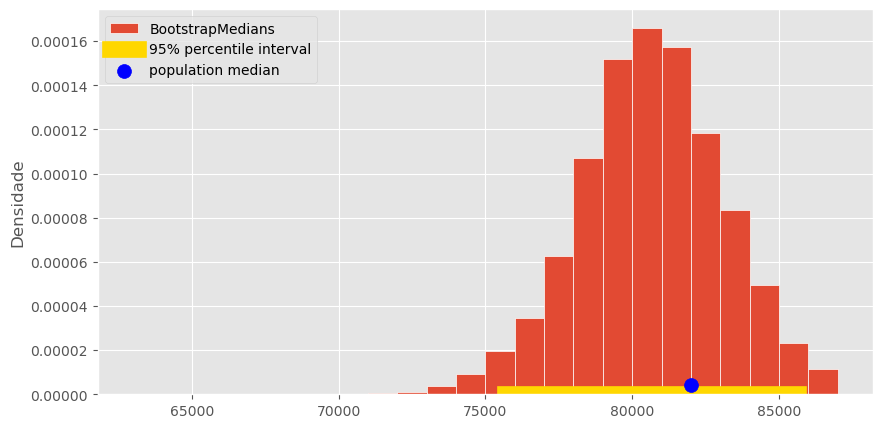

In [100]:
pd.DataFrame({"BootstrapMedians" : boot_medians}).plot(kind = 'hist', density = True, bins = np.arange(63000, 88000, 1000), ec = 'w', figsize = (10, 5))
plt.plot([L, U], [0, 0], color = 'gold', linewidth = 12, label = '95% percentile interval', zorder = 2);
plt.scatter(population_median, 0.000004, color = 'blue', s = 100, label = 'population median', zorder = 3)
plt.legend()
plt.ylabel("Densidade");

> Podemos afirmar então, com "$\gamma = 95\%$ _de confiança_", que a mediana populacional está entre \\$65.624,50 e \\$81.341,00.

- Isso é muito melhor do que simplesmente afirmar que "a mediana populacional é aproximadamente \\$73.264,50".

**Nota**: devido à maneira como os intervalos bootstrap são construídos, a mediana amostral \\$73.264,50 está _sempre_ contida em $[L, U]$.

### Exercício ✅

No ENEM (Exame Nacional do Ensino Médio) de 2024, aproximadamente 34 mil estudantes tiraram nota superior ou igual a 950 na prova de Redação. Sabendo que esses 34 mil estudantes correspondem à aproximadamente 1,38\% do total de estudantes que fizeram a prova, marque abaixo a alternativa **correta** quanto aos percentis de notas da prova de Redação.

**A**.  A nota 950 corresponde ao percentil 1,38 da distribuição de notas.

**B**.  Apenas 1,38\% dos estudantes tiveram uma nota pior ou igual a 950.

**C**.  A nota 950 corresponde ao percentil 98,62 da distribuição de notas.

**D**.  Apenas 1,38\% dos estudantes tiveram uma nota melhor ou igual a 950.

**E**.  Alternativas **A** e **B** estão corretas.

**F**. Alternativas **C** e **D** estão corretas.

## "Armadilhas" do bootstrap

### Regras de bolso

- O Bootstrap é uma técnica bem poderosa! Nós precisamos coletar apenas _uma única_ amostra para obter uma distribuição aproximada para a mediana amostral.

Porém, essa técnica tem suas limitações:
- O bootstrap não é muito bom para estatísticas mais "sensíveis" a valores extremos (como por exemplo o máximo, ou o mínimo).
    - Essa técnica funciona melhor para estatísticas que são mais "robustas" (a _outliers_).

- O boostrap fornece bons resultados apenas se a amostra é "suficientemente próxima" da população (o que ocorre se o tamanho amostral $n$ for "suficientemente grande").
    - Se nossa amostra original **não for representativa da população**, as amostras bootstrap também não serão representativas da população!

### Exemplo: Estimando o máximo de uma quantidade populacional

- Suponha que, ao invés da mediana, estejamos agora interessados no _máximo_ dos salários de todos os funcionários públicos da cidade de San Diego (nossa população).
- Nossa amostra coletada continua a mesma que tínhamos anteriormente, `my_sample`.
- Nossa estimativa será igual ao máximo dos salários amostrais (i.e. o maior salário contido na amostra). Esse máximo é uma _estatística_.

- Para obter uma distribuição amostral empírica do máximo amostral, fazemos então o seguinte bootstrap:

In [112]:
n_resamples = 5000
boot_maxes = np.array([])

for i in range(n_resamples):
    resample = my_sample.sample(500, replace=True)
    boot_max = resample['TotalWages'].max()
    boot_maxes = np.append(boot_maxes, boot_max)

In [113]:
boot_maxes

array([260845., 334473., 258995., ..., 334473., 334473., 260845.])

#### Visualizando os resultados

Como aqui temos acesso à população (lembro que em geral isso não acontece!), podemos encontrar o máximo populacional direto (sem bootstrap), apenas para comparação:

In [115]:
population_max = population['TotalWages'].max()
population_max

384909

Será então que o máximo populacional se encontra na parte com maior densidade na distribuição bootstrap, da mesma forma como aconteceu anteriormente com a mediana amostral?

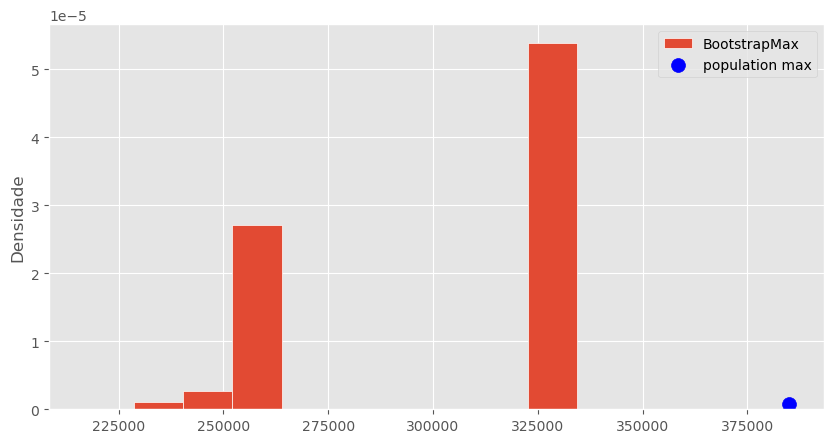

In [117]:
(pd.DataFrame({"BootstrapMax" : boot_maxes}).
    plot(kind = 'hist', 
        density = True, 
        bins = 10,
        ec = 'w',
        figsize = (10, 5))
)
plt.scatter(population_max, 0.0000008, color = 'blue', s = 100, label = 'population max')
plt.legend();
plt.ylabel("Densidade");

Na verdade não! A distribuição bootstrap não captura muito bem o máximo populacional, representado no histograma acima pelo <span style="color:blue"><b>ponto azul</b></span> igual a \$384,909.

> E porque não?! 🤔

In [119]:
my_sample['TotalWages'].max()

334473

- O maior valor na nossa amostra original é de \\$334,473. Logo, o maior valor na nossa amostra bootstrap será _no máximo igual_ a \\$334,473!
    - Em outras palavras, para estatísticas como o máximo _não teremos variabilidade o suficiente_ no bootstrap para aproximarmos bem a distribuição amostral, e como consequência o método não produz bons resultados.

- Em conclusão, o bootstrap funciona melhor para **medidas de tendência central ou dispersão** (como a média, mediana, desvio padrão, etc.) do que para medidas que são mais sensíveis a outliers, como **estatísticas de ordem** e/ou para extremos (máximo e mínimo).

## Resumo

- Com base em uma amostra, queremos inferir sobre um parâmetro populacional. Porém, como podemos calcular apenas uma estimativa com essa amostra, em geral não sabemos o quão _precisa_ é essa estimativa.
    
- Para termos uma ideia da variabilidade acerca da nossa estimativa, idealmente coletaríamos mais amostras e calcularíamos nossa estatística em cada uma dessas amostras. Porém, na prática, amostrar em geral é caro, e logo usualmente temos disponível **apenas uma amostra**.

- **Ideia principal**: Sob certas condições, a amostra é distribuída de maneira bem similar à população da qual a amostra foi coletada. Dessa forma, podemos tratar a distribuição empírica da amostra como se fosse a distribuição populacional, e produzir novas amostras **reamostrando** da amostra original.

- Cada nova amostra produzida dessa forma nos permite calcular uma nova estimativa. Com base em um conjunto dessas estimativas, podemos então ter uma noção da precisão/variabilidade da nossa estimativa original.

- O **Bootstrap** nos fornece uma maneira de gerarmos uma distribuição empírica de uma estatística, utilizando apenas uma única amostra original. Com base nessa **distribuição bootstrap**, podemos criar intervalos identificando os valores cujo intervalo contenha uma proporção $\gamma\%$ dessa distribuição.

- Podemos **quantificar a incerteza** sobre nossas estimativas utilizando intervalos bootstrap, e fazer afirmações do tipo "a mediana populacional está entre \\$65.624,50 e \\$81.341,00" com uma certa frequência de $95\%$ ao invés de afirmar apenas que "a mediana populacional é aproximadamente \\$73.264,50".

- O bootstrap funciona bem para estatísticas que não são sensíveis à pequenas variações na amostra (tais como a média e a mediana), mas não para máximos e mínimos.